In [ ]:
!pip install pandas scikit-learn matplotlib seaborn tensorflow

In [ ]:
import zipfile

zip_path = "/content/TurkishSMSProject.zip"  # ZIP dosyasının ismini buraya yaz
extract_path = "/content/sms_project"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("ZIP dosyası açıldı.")


FileNotFoundError: [Errno 2] No such file or directory: '/content/TurkishSMSProject.zip'

In [3]:
import zipfile

zip_path = "/content/archive.zip"  # ZIP dosyasının ismini buraya yaz
extract_path = "/content/sms_project"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("ZIP dosyası açıldı.")

ZIP dosyası açıldı.


In [4]:
import os

for root, dirs, files in os.walk(extract_path):
    for name in files:
        print(os.path.join(root, name))


/content/sms_project/TurkishSMSCollection.csv


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout


In [6]:
# CSV dosyasını oku
df = pd.read_csv('/content/archive.zip', sep=';')

# X: mesajlar, y: etiket (Spam=1, Normal=0)
X = df['Message'].values
y = (df['GroupText'] == 'Spam').astype(int).values

# Eğitim ve test olarak ayır
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)


In [7]:
# TF-IDF ile sayısal hale çevir
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Modeller
models = {
    "Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Linear SVM": LinearSVC()
}

# Eğitim ve değerlendirme
for name, model in models.items():
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)
    print(f"{name}: accuracy={accuracy_score(y_test, y_pred):.2f}, "
          f"precision={precision_score(y_test, y_pred):.2f}, "
          f"recall={recall_score(y_test, y_pred):.2f}, "
          f"F1={f1_score(y_test, y_pred):.2f}")


Naive Bayes: accuracy=0.96, precision=0.93, recall=0.99, F1=0.96
Logistic Regression: accuracy=0.99, precision=0.99, recall=0.99, F1=0.99
Linear SVM: accuracy=0.99, precision=0.99, recall=0.99, F1=0.99


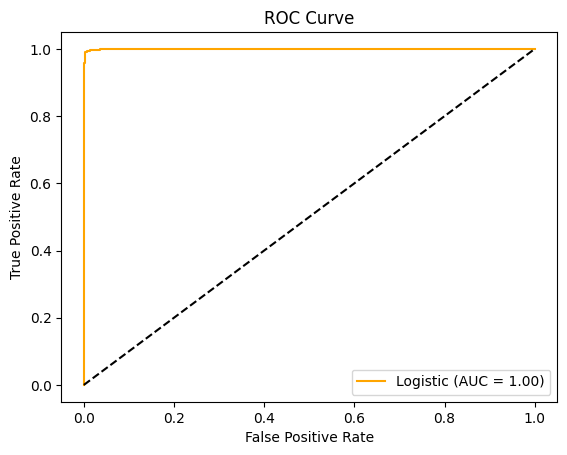

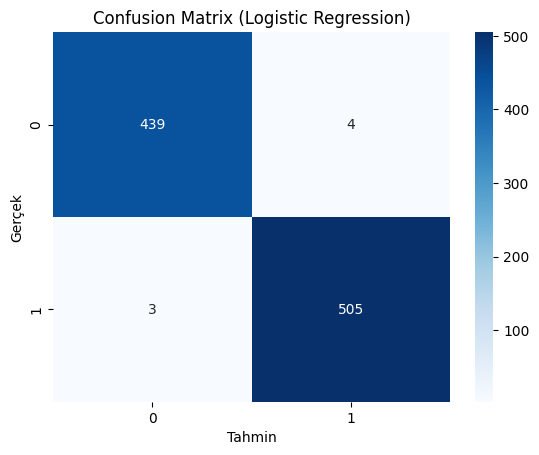

In [8]:
# Lojistik regresyon örneği için ROC
y_prob = models["Logistic Regression"].predict_proba(X_test_tfidf)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f'Logistic (AUC = {roc_auc:.2f})', color='orange')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_test, models["Logistic Regression"].predict(X_test_tfidf))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Tahmin')
plt.ylabel('Gerçek')
plt.title('Confusion Matrix (Logistic Regression)')
plt.show()


In [9]:
# Metinleri sayıya çevir
tokenizer = Tokenizer(num_words=5000, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

maxlen = 50
X_train_pad = pad_sequences(X_train_seq, maxlen=maxlen, truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=maxlen, truncating='post')

# LSTM modeli
model = Sequential([
    Embedding(input_dim=5000, output_dim=32, input_length=maxlen),
    LSTM(64, dropout=0.2, recurrent_dropout=0.2),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train_pad, y_train, epochs=5, batch_size=16, validation_split=0.1)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
214/214 ━━━━━━━━━━━━━━━━━━━━ 26s 89ms/step - accuracy: 0.9062 - loss: 0.3034 - val_accuracy: 0.9947 - val_loss: 0.0240
Epoch 2/5
214/214 ━━━━━━━━━━━━━━━━━━━━ 15s 64ms/step - accuracy: 0.9934 - loss: 0.0193 - val_accuracy: 0.9947 - val_loss: 0.0272
Epoch 3/5
214/214 ━━━━━━━━━━━━━━━━━━━━ 20s 63ms/step - accuracy: 0.9997 - loss: 0.0050 - val_accuracy: 0.9947 - val_loss: 0.0153
Epoch 4/5
214/214 ━━━━━━━━━━━━━━━━━━━━ 14s 65ms/step - accuracy: 1.0000 - loss: 0.0025 - val_accuracy: 0.9947 - val_loss: 0.0103
Epoch 5/5
214/214 ━━━━━━━━━━━━━━━━━━━━ 17s 79ms/step - accuracy: 1.0000 - loss: 7.5825e-04 - val_accuracy: 0.9921 - val_loss: 0.0224


In [10]:
# Yeni SMS mesajı (örnek)
new_sms = ["Bugün hava çok güzel, dışarı çıkalım mı?"]

# Mesajı TF-IDF ile sayısal hale getir (aynı vectorizer kullanılarak)
new_sms_tfidf = vectorizer.transform(new_sms)

# Model ile tahmin et
pred = models["Logistic Regression"].predict(new_sms_tfidf)

print("Spam" if pred[0] == 1 else "Normal")


Normal


In [11]:
# Yeni SMS'i tokenize et ve padding uygula
new_sms_seq = tokenizer.texts_to_sequences(new_sms)
new_sms_pad = pad_sequences(new_sms_seq, maxlen=maxlen, truncating='post')

# Tahmin yap
pred_dl = (model.predict(new_sms_pad) > 0.5).astype(int).flatten()

print("Spam" if pred_dl[0] == 1 else "Normal")


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Normal
